✅ Libraries imported successfully!
📊 Data Loading Summary:
Stocks data: (50, 7)
Prices data: (12600, 8)

📈 Stocks Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   stock_id        50 non-null     object 
 1   symbol          50 non-null     object 
 2   company_name    50 non-null     object 
 3   sector          50 non-null     object 
 4   market_cap      50 non-null     object 
 5   dividend_yield  50 non-null     float64
 6   beta            50 non-null     float64
dtypes: float64(2), object(5)
memory usage: 2.9+ KB
None

💰 Prices Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12600 entries, 0 to 12599
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   stock_id      12600 non-null  object 
 1   date          12600 non-null  object 
 2   open 

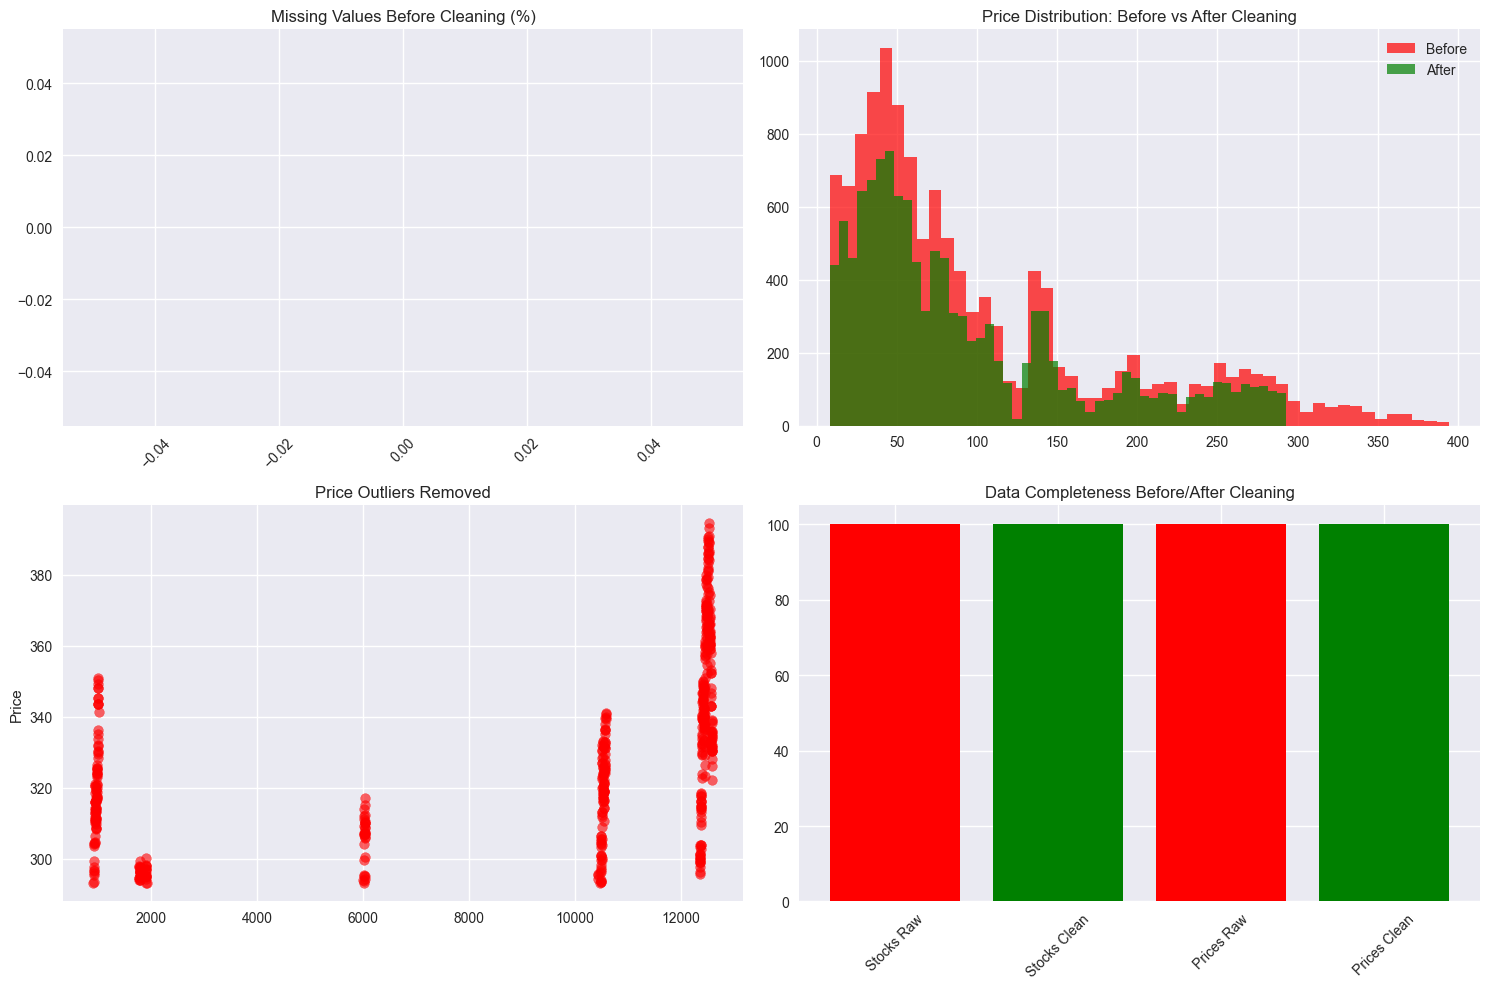

💾 Cleaned data saved successfully!

📊 Cleaning Summary:
Stocks: 50 records (100.0% retained)
Prices: 12104 records (96.1% retained)
Date range: 2023-01-01 00:00:00 to 2023-09-09 00:00:00
Unique stocks: 50

📈 Sample of Cleaned Stocks Data:
  stock_id symbol              company_name      sector market_cap  \
0   STK100   S000     First Healthcare Inc.  Healthcare      Large   
1   STK101   S001    National Consumer Inc.    Consumer      Large   
2   STK102   S002    Global Healthcare Inc.  Healthcare      Small   
3   STK103   S003     Global Utilities Inc.   Utilities      Large   
4   STK104   S004  National Healthcare Inc.  Healthcare      Large   

   dividend_yield  beta  
0          0.0050  1.63  
1          0.0178  1.38  
2          0.0113  1.43  
3          0.0122  1.01  
4          0.0138  1.46  

💰 Sample of Cleaned Prices Data:
  stock_id       date        open        high         low       close  \
0   STK100 2023-01-01  143.081255  144.462618  141.926348  143.635030   
1   

In [2]:
# Financial Stock Analysis - Data Cleaning\n",
## Step 1: Data Loading and Preparation",
# Import libraries\n",
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Setup plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully!")
# Load the raw data\n",
stocks = pd.read_csv('../../data/raw/financial_stocks.csv')
prices = pd.read_csv('../../data/raw/financial_prices.csv')

print("📊 Data Loading Summary:")
print(f"Stocks data: {stocks.shape}")
print(f"Prices data: {prices.shape}")

print("\n📈 Stocks Data Info:")
print(stocks.info())

print("\n💰 Prices Data Info:")
print(prices.info())
## Data Quality Assessment"],
def assess_data_quality(df, df_name):
    """Comprehensive data quality assessment"""
    print(f"\n🔍 Data Quality Assessment: {df_name}")
    print("=" * 50)
    
    # Basic info
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    
    # Missing values
    missing_data = df.isnull().sum()
    missing_pct = (missing_data / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing_data,
        'Missing %': missing_pct
    })
    print("\nMissing Values:")
    print(missing_df[missing_df['Missing Count'] > 0])
    
    # Duplicates
    duplicates = df.duplicated().sum()
    print(f"\nDuplicate Rows: {duplicates}")
    # Data types
    print("\nData Types:")
    print(df.dtypes)
    
    return missing_df
# Assess both datasets\n",
stocks_missing = assess_data_quality(stocks, "Stocks Data")
prices_missing = assess_data_quality(prices, "Prices Data")
## Data Cleaning Process
# Create cleaned copies of the datasets
stocks_clean = stocks.copy()
prices_clean = prices.copy()

print("🔄 Starting Data Cleaning Process...")

# 1. Handle missing values
print("\n1. Handling missing values...")

# Stocks: Fill missing dividend_yield with 0
stocks_clean['dividend_yield'] = stocks_clean['dividend_yield'].fillna(0)

# Prices: Forward fill then backward fill for OHLC data
numeric_cols = ['open', 'high', 'low', 'close', 'volume']
for col in numeric_cols:
    prices_clean[col] = prices_clean[col].fillna(method='ffill').fillna(method='bfill')

print("\n2. Converting data types...")
prices_clean['date'] = pd.to_datetime(prices_clean['date'])

# Ensure numeric types
for col in numeric_cols:
    prices_clean[col] = pd.to_numeric(prices_clean[col], errors='coerce')

# 3. Remove duplicates
print("\n3. Removing duplicates...")
stocks_clean = stocks_clean.drop_duplicates(subset=['stock_id'])
prices_clean = prices_clean.drop_duplicates(subset=['stock_id', 'date'])

# 4. Handle outliers using IQR method
print("\n4. Handling outliers...")
def remove_outliers_iqr(df, column):
    """Remove outliers using IQR method"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR    
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return cleaned, outliers
               
# Remove extreme price outliers\n",
prices_clean, price_outliers = remove_outliers_iqr(prices_clean, 'close')
print(f"Removed {len(price_outliers)} price outliers")

# 5. Data validation
print("\n5. Validating data consistency...")
                
# Check for negative prices
negative_prices = prices_clean[prices_clean['close'] <= 0]
print(f"Negative/zero prices found: {len(negative_prices)}")

# Remove any remaining negative prices
prices_clean = prices_clean[prices_clean['close'] > 0]

# Validate OHLC relationships
invalid_ohlc = prices_clean[
                    (prices_clean['high'] < prices_clean['low']) |
                    (prices_clean['open'] > prices_clean['high']) |
                    (prices_clean['open'] < prices_clean['low']) |
                    (prices_clean['close'] > prices_clean['high']) |
                    (prices_clean['close'] < prices_clean['low'])
                ]
print(f"Invalid OHLC records: {len(invalid_ohlc)}")

# Fix OHLC relationships
prices_clean['high'] = prices_clean[['open', 'high', 'low', 'close']].max(axis=1)
prices_clean['low'] = prices_clean[['open', 'high', 'low', 'close']].min(axis=1)
print("✅ Data cleaning completed!")
print("✅ Data cleaning completed!")
## Data Quality Visualization
# Create visualization of data quality
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Missing values before cleaning
missing_before = pd.concat([stocks_missing, prices_missing])
missing_before = missing_before[missing_before['Missing Count'] > 0]
axes[0,0].bar(missing_before.index, missing_before['Missing %'])
axes[0,0].set_title('Missing Values Before Cleaning (%)')
axes[0,0].tick_params(axis='x', rotation=45)
# Price distribution before and after cleaning\n",
axes[0,1].hist(prices['close'].dropna(), bins=50, alpha=0.7, label='Before', color='red')
axes[0,1].hist(prices_clean['close'], bins=50, alpha=0.7, label='After', color='green')
axes[0,1].set_title('Price Distribution: Before vs After Cleaning')
axes[0,1].legend()
# Outliers removed
axes[1,0].scatter(price_outliers.index, price_outliers['close'], color='red', alpha=0.6)
axes[1,0].set_title('Price Outliers Removed')
axes[1,0].set_ylabel('Price')
# Data completeness
completeness_data = {
    'Dataset': ['Stocks Raw', 'Stocks Clean', 'Prices Raw', 'Prices Clean'],
    'Records': [len(stocks), len(stocks_clean), len(prices), len(prices_clean)],
    'Completeness %': [100, 100, 
                (1 - prices.isnull().sum().sum() / (prices.shape[0] * prices.shape[1])) * 100,
                100]
}
completeness_df = pd.DataFrame(completeness_data)

axes[1,1].bar(completeness_df['Dataset'], completeness_df['Completeness %'], color=['red', 'green', 'red', 'green'])
axes[1,1].set_title('Data Completeness Before/After Cleaning')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
## Save Cleaned Data
stocks_clean.to_csv('../../data/processed/stocks_cleaned.csv', index=False)
prices_clean.to_csv('../../data/processed/prices_cleaned.csv', index=False)

print("💾 Cleaned data saved successfully!")
# Summary statistics
print("\n📊 Cleaning Summary:")
print(f"Stocks: {len(stocks_clean)} records ({(len(stocks_clean)/len(stocks)*100):.1f}% retained)")
print(f"Prices: {len(prices_clean)} records ({(len(prices_clean)/len(prices)*100):.1f}% retained)")
print(f"Date range: {prices_clean['date'].min()} to {prices_clean['date'].max()}")
print(f"Unique stocks: {prices_clean['stock_id'].nunique()}")

print("\n📈 Sample of Cleaned Stocks Data:")
print(stocks_clean.head())

print("\n💰 Sample of Cleaned Prices Data:")
print(prices_clean.head())
## Data Quality Report
# Generate data quality report\n",
def generate_quality_report(original, cleaned, dataset_name):
    """Generate comprehensive data quality report"""
    print(f"\n📋 Data Quality Report: {dataset_name}")
    print("=" * 60)
    
    # Records retained\n",
    retained_pct = (len(cleaned) / len(original)) * 100
    print(f"Records retained: {len(cleaned)}/{len(original)} ({retained_pct:.1f}%)")
    
    # Missing values after cleaning
    missing_after = cleaned.isnull().sum().sum()    
    print(f"Missing values after cleaning: {missing_after}")
    
    # Data types
    print(f"\nData types in cleaned data:")
    for col, dtype in cleaned.dtypes.items():
        print(f"  {col}: {dtype}")
    
    return {
        'dataset': dataset_name,
        'original_records': len(original),
        'cleaned_records': len(cleaned),
        'retention_rate': retained_pct,
        'missing_after': missing_after
    }
stocks_report = generate_quality_report(stocks, stocks_clean, "Stocks Data")
prices_report = generate_quality_report(prices, prices_clean, "Prices Data")

print("\n🎯 Data cleaning process completed successfully!")
print("Next: Proceed to Exploratory Data Analysis (02_eda.ipynb)")
 